In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm  # Para a suavização LOWESS

In [2]:
# Carregando e Tratando o dataset
df = pd.read_excel("https://www.sspds.ce.gov.br/wp-content/uploads/sites/24/2025/03/CVLI_2009-2024.xlsx", engine="openpyxl")
df = df.query("Município == 'Fortaleza'")
df["Natureza"].unique()

array(['HOMICIDIO DOLOSO', 'ROUBO SEGUIDO DE MORTE (LATROCINIO)',
       'LESAO CORPORAL SEGUIDA DE MORTE', 'FEMINICÍDIO'], dtype=object)

In [10]:
df.head()

,Município,AIS,Natureza,Data,Hora,Dia da Semana,Meio Empregado,Gênero,Idade da Vítima,Escolaridade da Vítima,Raça da Vítima
4,Fortaleza,AIS 10,HOMICIDIO DOLOSO,2009-01-01,00:00:00,Quinta,Arma de fogo,Masculino,Não Informada,Não Informada,Não Informada
5,Fortaleza,AIS 01,HOMICIDIO DOLOSO,2009-01-01,00:00:00,Quinta,Arma de fogo,Masculino,Não Informada,Não Informada,Não Informada
6,Fortaleza,AIS 08,HOMICIDIO DOLOSO,2009-01-01,00:00:00,Quinta,Arma de fogo,Masculino,Não Informada,Não Informada,Não Informada
10,Fortaleza,AIS 02,HOMICIDIO DOLOSO,2009-01-01,00:00:00,Quinta,Arma branca,Masculino,Não Informada,Não Informada,Não Informada
11,Fortaleza,AIS 08,HOMICIDIO DOLOSO,2009-01-01,00:00:00,Quinta,Arma branca,Masculino,Não Informada,Não Informada,Não Informada


In [3]:
def get_time_group(df, time_col='date', time_unit='Y'):
    """
    Adiciona uma coluna de agrupamento temporal ao DataFrame.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada
    time_col : str, optional
        Nome da coluna de tempo. Padrão: 'date'
    time_unit : str, optional
        Unidade de tempo ('Y' para ano, 'M' para mês, 'D' para dia).
        Padrão: 'Y'

    Retorna:
    --------
    pd.DataFrame
        DataFrame com a coluna 'time_group' adicionada (sempre numérica ou datetime)
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])

    if time_unit == 'Y':
        df['time_group'] = df[time_col].dt.year
        df['time_group_str'] = df['time_group'].astype(str)  # Versão string para rótulos
    elif time_unit == 'M':
        df['time_group'] = df[time_col].dt.to_period('M').dt.to_timestamp()
        df['time_group_str'] = df['time_group'].dt.strftime('%Y-%m')
    elif time_unit == 'D':
        df['time_group'] = df[time_col].dt.normalize()
        df['time_group_str'] = df['time_group'].dt.strftime('%Y-%m-%d')
    else:
        raise ValueError("Unidade de tempo não suportada. Use 'Y', 'M' ou 'D'.")

    return df

In [4]:
def _prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    """Prepara os dados para plotagem, ordenando e agrupando."""
    df = df.sort_values('time_group')
    return df.groupby("time_group").size().reset_index(name="Total")

def _plot_bar_chart(
    grouped: pd.DataFrame,
    df: pd.DataFrame,
    ax: plt.Axes,
    color_palette: str,
    xlabel: str,
    ylabel: str,
    title: str,
    time_unit: str,
    rotation: int
) -> None:
    """Plota o gráfico de barras da série temporal."""
    sns.barplot(
        data=grouped,
        x='time_group',
        y='Total',
        palette=color_palette,
        ax=ax
    )

    if 'time_group_str' in df.columns:
        labels = df.drop_duplicates('time_group').sort_values('time_group')['time_group_str']
        ax.set_xticklabels(labels)

    if title:
        ax.set_title(f"{title}\n(Distribuição Temporal)", pad=15)
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if time_unit in ['M', 'D']:
        ax.tick_params(axis='x', rotation=rotation, ha='right')

    sns.despine(ax=ax)
    ax.grid(axis='y', alpha=0.3)

def _plot_trend_line(
    grouped: pd.DataFrame,
    ax: plt.Axes,
    trend_color: str,
    xlabel: str,
    ylabel: str,
    rotation: int
) -> None:
    """Plota a linha de tendência suavizada."""
    x = grouped['time_group']
    y = grouped['Total']

    x_num = x.astype(np.int64) // 10**9 if pd.api.types.is_datetime64_any_dtype(x) else x.astype(float)

    sns.regplot(
        x=x_num,
        y=y,
        lowess=True,
        scatter=True,
        line_kws={'color': trend_color, 'lw': 2},
        scatter_kws={'color': trend_color, 's': 40},
        ax=ax
    )

    ax.set_title("Tendência Suavizada", pad=15)
    ax.set_ylabel(ylabel)

    if pd.api.types.is_datetime64_any_dtype(x):
        locs = ax.get_xticks()
        labels = pd.to_datetime(locs * 10**9).strftime('%Y-%m-%d')
        ax.set_xticks(locs)
        ax.set_xticklabels(labels, rotation=rotation)
        ax.set_xlabel("Período")
    else:
        ax.set_xlabel(xlabel or "Período")
        ax.tick_params(axis='x', rotation=rotation)

    ax.grid(alpha=0.3)
    sns.despine(ax=ax)

def time_series_with_trend(
    df: pd.DataFrame,
    size: tuple = (16, 6),
    title: str = None,
    xlabel: str = None,
    ylabel: str = "Ocorrências",
    time_unit: str = 'Y',
    color_palette: str = "Blues",
    rotation: int = 45,
    trend_color: str = "crimson"
) -> None:
    """
    Plota uma série temporal com linha de tendência suavizada.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame com coluna 'time_group' (datetime ou numérica)
    size : tuple, optional
        Tamanho da figura. Padrão: (16, 6)
    title : str, optional
        Título do gráfico
    xlabel : str, optional
        Rótulo do eixo x
    ylabel : str, optional
        Rótulo do eixo y. Padrão: "Ocorrências"
    time_unit : str, optional
        Unidade de tempo ('Y', 'M' ou 'D'). Padrão: 'Y'
    color_palette : str, optional
        Paleta de cores do seaborn. Padrão: "Blues"
    rotation : int, optional
        Rotação dos rótulos do eixo x. Padrão: 45
    trend_color : str, optional
        Cor da linha de tendência. Padrão: "crimson"
    """
    # Preparar dados
    grouped = _prepare_data(df)

    # Criar figura e subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size)

    # Plotar gráfico de barras
    _plot_bar_chart(
        grouped=grouped,
        df=df,
        ax=ax1,
        color_palette=color_palette,
        xlabel=xlabel,
        ylabel=ylabel,
        title=title,
        time_unit=time_unit,
        rotation=rotation
    )

    # Plotar linha de tendência
    _plot_trend_line(
        grouped=grouped,
        ax=ax2,
        trend_color=trend_color,
        xlabel=xlabel,
        ylabel=ylabel,
        rotation=rotation
    )

    plt.tight_layout()
    plt.show()

**VERSÃO INTERATIVA**

In [36]:
def time_series_with_trend_interactive(
    df: pd.DataFrame,
    time_col: str = 'Data',
    size: tuple = (1000, 500),
    title: str = None,
    xlabel: str = None,
    ylabel: str = "Ocorrências",
    time_unit: str = 'Y',
    color_palette: str = "Blues",
    rotation: int = 45,
    trend_color: str = "crimson"
) -> None:
    """
    Plota uma série temporal interativa com linha de tendência suavizada.
    Versão corrigida e testada para DataFrames com coluna 'Data'.

    Parâmetros:
    -----------
    df : pd.DataFrame
        DataFrame de entrada contendo a coluna temporal
    time_col : str, optional
        Nome da coluna de tempo. Padrão: 'Data'
    size : tuple, optional
        Tamanho da figura em pixels. Padrão: (1000, 500)
    title : str, optional
        Título do gráfico
    xlabel : str, optional
        Rótulo do eixo x
    ylabel : str, optional
        Rótulo do eixo y. Padrão: "Ocorrências"
    time_unit : str, optional
        Unidade de tempo ('Y', 'M' ou 'D'). Padrão: 'Y'
    color_palette : str, optional
        Nome da paleta de cores do Plotly. Padrão: "Blues"
    rotation : int, optional
        Rotação dos rótulos do eixo x. Padrão: 45
    trend_color : str, optional
        Cor da linha de tendência. Padrão: "crimson"
    """
    # Verificação da coluna temporal
    if time_col not in df.columns:
        available_cols = [col for col in df.columns if col.lower() in ['data', 'date', 'tempo', 'time']]
        suggestions = f" Talvez você queira usar: {available_cols[0]}" if available_cols else ""
        raise KeyError(
            f"Coluna temporal '{time_col}' não encontrada.{suggestions}\n"
            f"Colunas disponíveis: {list(df.columns)}"
        )

    # Processamento dos dados
    try:
        df_processed = get_time_group(df, time_col=time_col, time_unit=time_unit)
    except Exception as e:
        raise ValueError(f"Erro ao processar dados temporais: {str(e)}")

    # Agrupar os dados
    grouped = df_processed.groupby("time_group").size().reset_index(name="Total")
    grouped = grouped.sort_values("time_group")

    # Obter cores da paleta do Plotly corretamente
    try:
        colors = getattr(px.colors.sequential, color_palette)
    except AttributeError:
        colors = px.colors.sequential.Blues  # Fallback para Blues

    # Criar figura com subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=("Distribuição Temporal", "Tendência Suavizada"),
        horizontal_spacing=0.1
    )

    try:
        palette = getattr(px.colors.sequential, color_palette)
        # Selecionar cores igualmente espaçadas da paleta para cada barra
        n_bars = len(grouped)
        colors = [palette[i % len(palette)] for i in range(n_bars)]
    except AttributeError:
        colors = px.colors.sequential.Blues  # Fallback para Blues
        colors = [colors[i % len(colors)] for i in range(len(grouped))]

    # Adicionar gráfico de barras
    fig.add_trace(
        go.Bar(
            x=grouped["time_group"],
            y=grouped["Total"],
            marker=dict(
                color=colors,  # Usar a lista de cores personalizada
                line=dict(color='rgba(0,0,0,0.3)', width=1)  # Borda sutil
            ),
            name="Ocorrências",
            hovertemplate="<b>%{x}</b><br>Ocorrências: %{y}<extra></extra>"
        ),
        row=1, col=1
    )

    # Preparar dados para tendência
    x = grouped["time_group"]
    y = grouped["Total"]

    # Converter para numérico se for datetime
    if pd.api.types.is_datetime64_any_dtype(x):
        x_num = x.astype(np.int64) // 10**9
        x_labels = x.dt.strftime('%Y-%m-%d' if time_unit == 'D' else '%Y-%m')
    else:
        x_num = x.astype(float)
        x_labels = x.astype(str)

    # Adicionar linha de tendência (LOWESS)
    lowess = sm.nonparametric.lowess(y, x_num, frac=1/3)
    fig.add_trace(
        go.Scatter(
            x=x,
            y=lowess[:, 1],
            mode='lines',
            line=dict(color=trend_color, width=3),
            name='Tendência',
            hovertemplate="<b>%{x}</b><br>Tendência: %{y:.1f}<extra></extra>"
        ),
        row=1, col=2
    )


    # Adicionar pontos de dados
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode='markers',
            marker=dict(color=trend_color, size=8),
            name='Dados',
            hovertemplate="<b>%{x}</b><br>Ocorrências: %{y}<extra></extra>",
            showlegend=False
        ),
        row=1, col=2
    )

    # Configurações de layout
    fig.update_layout(
        title_text=f"{title}<br><sup>Análise Temporal</sup>" if title else None,
        width=size[0],
        height=size[1],
        showlegend=True,
        hovermode="x unified",
        template="plotly_white",
        margin=dict(l=50, r=50, b=80, t=80 if title else 50)
    )

    # Configurações dos eixos
    date_format = '%Y-%m-%d' if time_unit == 'D' else '%Y-%m' if time_unit == 'M' else None

    fig.update_xaxes(
        title_text=xlabel or "Período",
        row=1, col=1,
        tickangle=rotation if time_unit in ['M', 'D'] else 0,
        tickformat=date_format
    )

    fig.update_xaxes(
        title_text=xlabel or "Período",
        row=1, col=2,
        tickangle=rotation if time_unit in ['M', 'D'] else 0,
        tickformat=date_format
    )

    fig.update_yaxes(title_text=ylabel, row=1, col=1)
    fig.update_yaxes(title_text=ylabel, row=1, col=2)

    fig.show()

/tmp/ipython-input-4-837325555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4-837325555.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


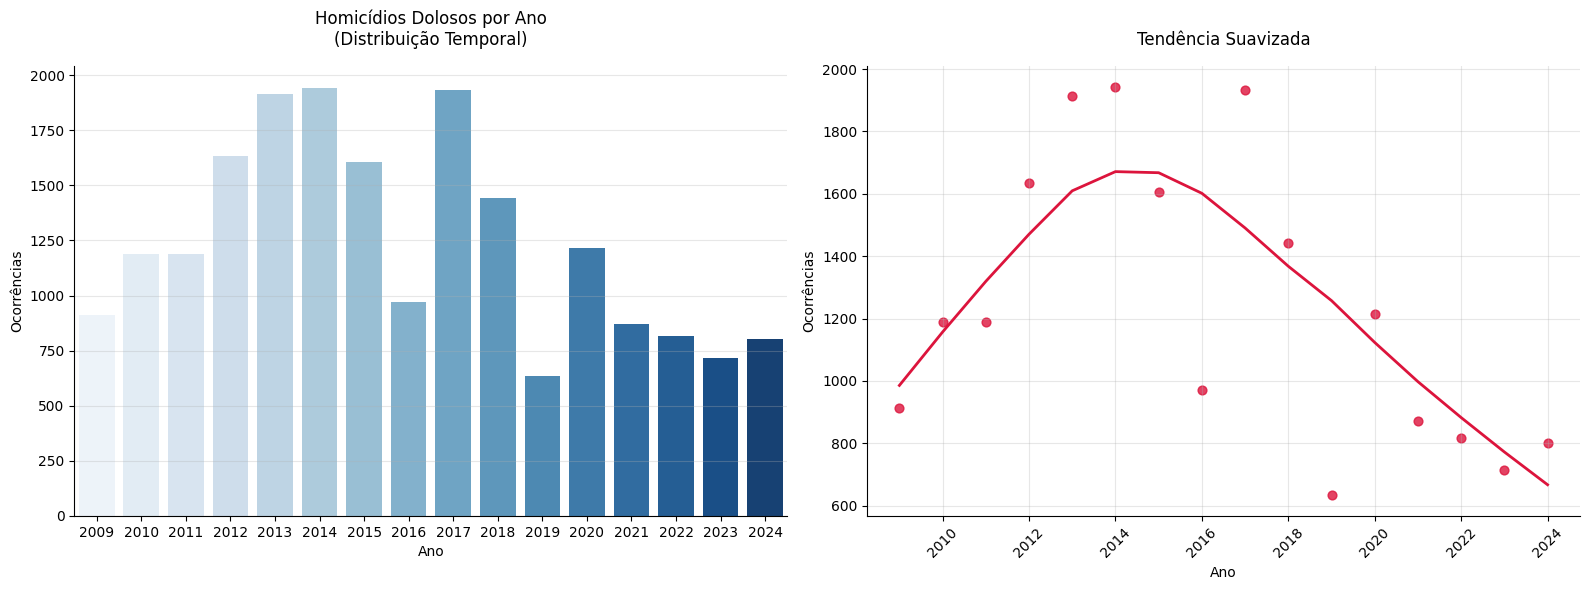

In [6]:
time_series_with_trend(get_time_group(df.query("Natureza == 'HOMICIDIO DOLOSO'").copy(),
                             time_col="Data",
                             time_unit='Y'),
                      title="Homicídios Dolosos por Ano",
                      xlabel="Ano")

/tmp/ipython-input-4-837325555.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-4-837325555.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


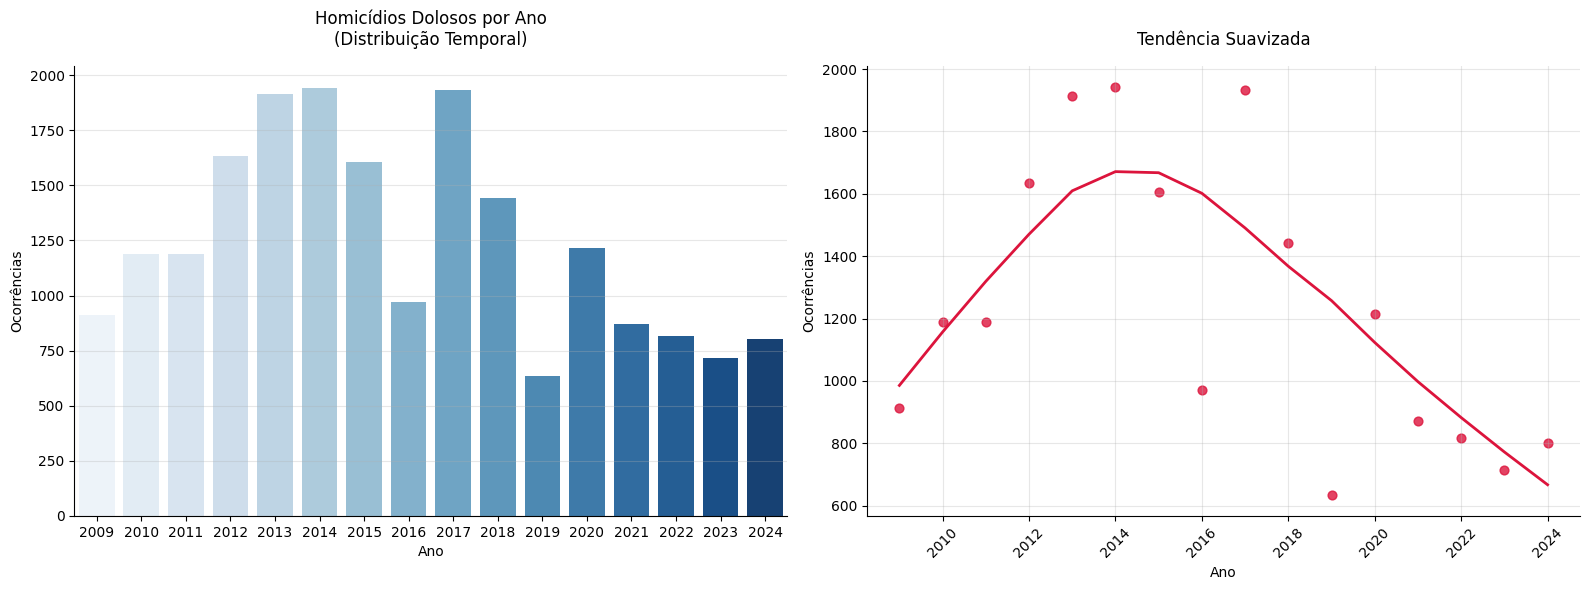

In [7]:
time_series_with_trend(get_time_group(df.query("Natureza == 'HOMICIDIO DOLOSO'").copy(),
                             time_col="Data",
                             time_unit='Y'),
                      title="Homicídios Dolosos por Ano",
                      xlabel="Ano")

In [37]:
# Exemplo com seus dados
time_series_with_trend_interactive(
    df=df,
    time_col='Data',  # Nome da sua coluna de data
    time_unit='Y',    # Agrupar por ano ('Y', 'M' ou 'D')
    title="Análise Temporal de Crimes",
    xlabel="Ano",
    ylabel="Número de Ocorrências",
    color_palette="Viridis"  # Paletas disponíveis: https://plotly.com/python/builtin-colorscales/
)

In [23]:
# Exemplo com seus dados
time_series_with_trend_interactive(
    df=df,
    time_col='Data',  # Nome da sua coluna de data
    time_unit='M',    # Agrupar por ano ('Y', 'M' ou 'D')
    title="Análise Temporal de Crimes",
    xlabel="Ano",
    ylabel="Número de Ocorrências",
    color_palette="Viridis"  # Paletas disponíveis: https://plotly.com/python/builtin-colorscales/
)

In [34]:
def interactive_monthly_view(df, date_col='Data'):
    """
    Cria uma visualização interativa por mês com seletor de ano.
    Versão com posicionamento melhorado do seletor.
    """
    # Pré-processamento dos dados (mantido igual)
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df['Ano'] = df[date_col].dt.year
    df['Mês'] = df[date_col].dt.month
    df['Mês_Ano'] = df[date_col].dt.to_period('M').dt.to_timestamp()
    df['Nome_Mês'] = df[date_col].dt.strftime('%b')

    # Criar DataFrame agregado (mantido igual)
    monthly_data = df.groupby(['Ano', 'Mês', 'Mês_Ano', 'Nome_Mês']).size().reset_index(name='Total')
    monthly_data = monthly_data.sort_values(['Ano', 'Mês'])
    years = sorted(monthly_data['Ano'].unique())

    # Criar figura (mantido igual)
    fig = go.Figure()

    # Adicionar traces para cada ano (mantido igual)
    for year in years:
        year_data = monthly_data[monthly_data['Ano'] == year]
        fig.add_trace(
            go.Bar(
                x=year_data['Nome_Mês'],
                y=year_data['Total'],
                visible=(year == years[0]),
                marker_color='blue',
                name=str(year),
                hovertemplate='Mês: %{x}<br>Ocorrências: %{y}<extra></extra>'
            )
        )

    # Botões com posicionamento ajustado
    buttons = []
    for i, year in enumerate(years):
        visibility = [False] * len(years)
        visibility[i] = True

        buttons.append(
            dict(
                label=str(year),
                method='update',
                args=[{'visible': visibility},
                      {'title': f'Distribuição Mensal - Ano {year}',
                       'xaxis': {'tickvals': year_data['Mês'].unique(),
                                'ticktext': year_data['Nome_Mês'].unique()}}]
            )
        )

    # Layout com posicionamento melhorado
    fig.update_layout(
        title={
            'text': f'Distribuição Mensal - Ano {years[0]}',
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Mês',
        yaxis_title='Número de Ocorrências',
        xaxis=dict(
            tickmode='array',
            tickvals=monthly_data[monthly_data['Ano'] == years[0]]['Mês'].unique(),
            ticktext=monthly_data[monthly_data['Ano'] == years[0]]['Nome_Mês'].unique()
        ),
        updatemenus=[{
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
            'x': 0.5,  # Centralizado horizontalmente
            'y': 1.0,  # Posicionado acima do título
            'xanchor': 'center',
            'yanchor': 'bottom',
            'pad': {'t': 40}  # Espaçamento adicional no topo
        }],
        template='plotly_white',
        margin=dict(t=100)  # Margem superior aumentada
    )

    fig.show()

In [35]:
interactive_monthly_view(df, date_col='Data')

<ipython-input-63-13a8f8f5e646>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-63-13a8f8f5e646>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


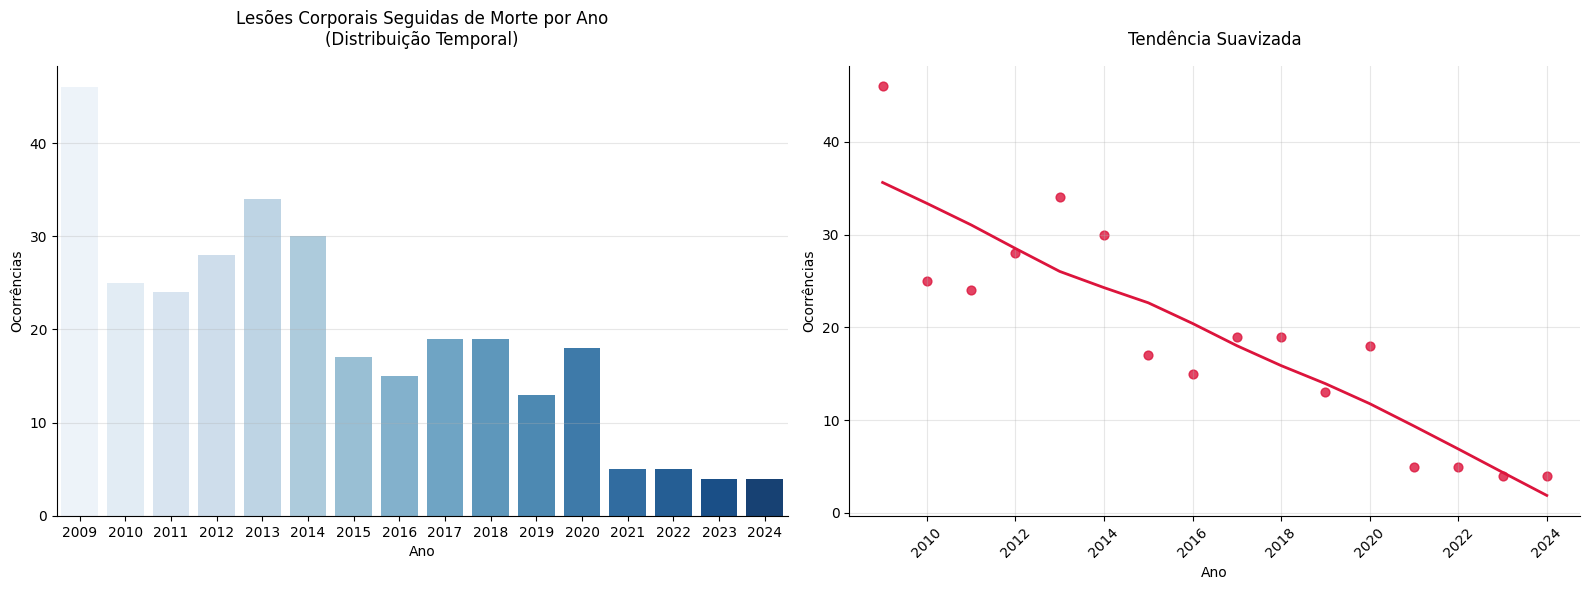

In [ ]:
time_series_with_trend(get_time_group(df.query("Natureza == 'LESAO CORPORAL SEGUIDA DE MORTE'").copy(),
                             time_col="Data",
                             time_unit='Y'),
                      title="Lesões Corporais Seguidas de Morte por Ano",
                      xlabel="Ano")

<ipython-input-63-13a8f8f5e646>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-63-13a8f8f5e646>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


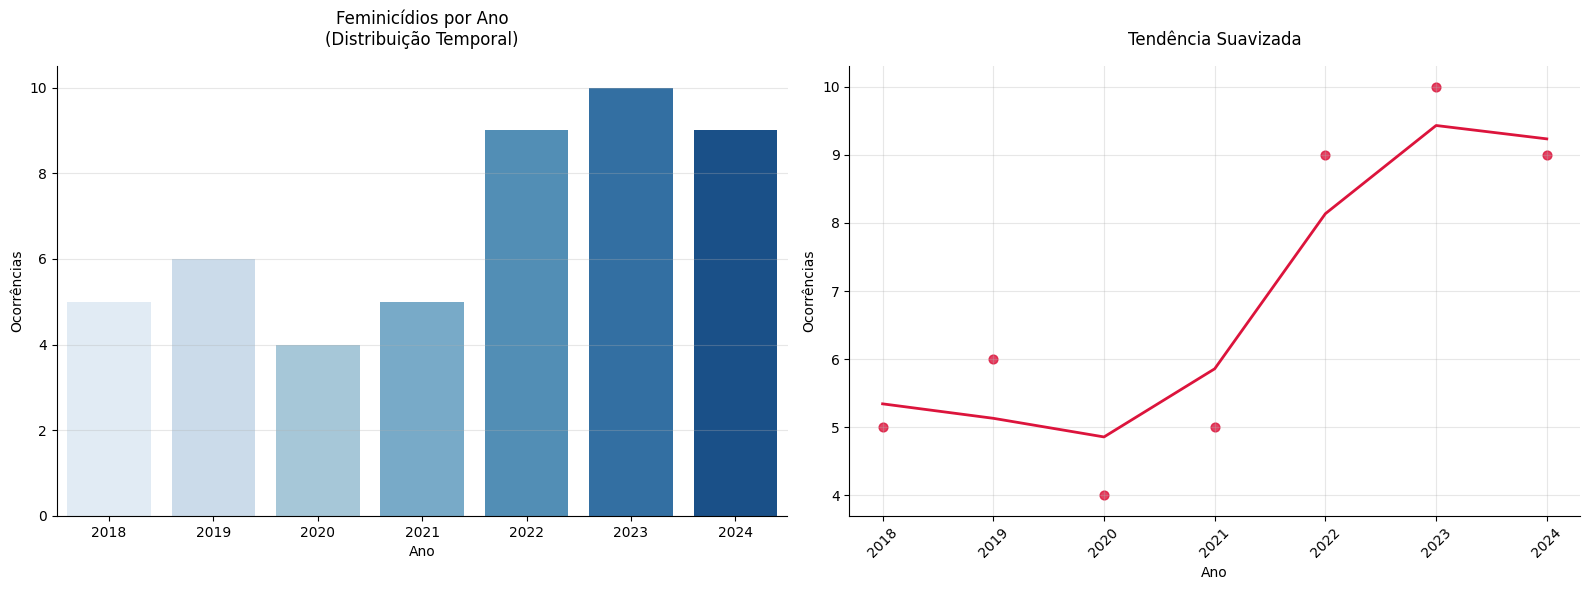

In [ ]:
time_series_with_trend(get_time_group(df.query("Natureza == 'FEMINICÍDIO'").copy(),
                             time_col="Data",
                             time_unit='Y'),
                      title="Feminicídios por Ano",
                      xlabel="Ano")

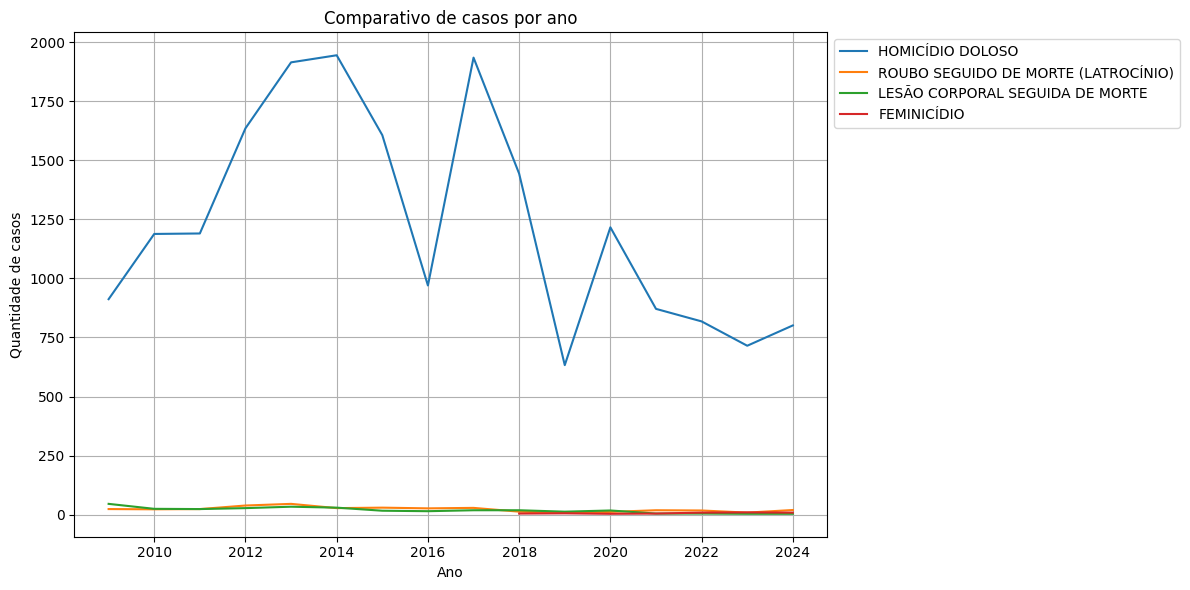

In [ ]:
# Agrupando os dados por ano para criar séries temporais dos diferentes tipos de crimes
serie_homicidio = df.query("Natureza == 'HOMICIDIO DOLOSO'").groupby("Ano").size()
serie_latrocinio = df.query("Natureza == 'ROUBO SEGUIDO DE MORTE (LATROCINIO)'").groupby("Ano").size()
serie_lesao = df.query("Natureza == 'LESAO CORPORAL SEGUIDA DE MORTE'").groupby("Ano").size()
serie_feminicidio = df.query("Natureza == 'FEMINICÍDIO'").groupby("Ano").size()

# Criando o gráfico de linha para comparar os tipos de crimes ao longo dos anos
plt.figure(figsize=(12, 6))
plt.plot(serie_homicidio.index, serie_homicidio.values, label="HOMICÍDIO DOLOSO")
plt.plot(serie_latrocinio.index, serie_latrocinio.values, label="ROUBO SEGUIDO DE MORTE (LATROCÍNIO)")
plt.plot(serie_lesao.index, serie_lesao.values, label="LESÃO CORPORAL SEGUIDA DE MORTE")
plt.plot(serie_feminicidio.index, serie_feminicidio.values, label="FEMINICÍDIO")

# Personalizando o gráfico: título, rótulos dos eixos, legenda e layout
plt.title("Comparativo de casos por ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade de casos")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Criando a coluna mês
df["Mês"] = df["Data"].dt.month

<ipython-input-79-5fed13319e33>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mensal.index, y=mensal.values, palette='viridis')


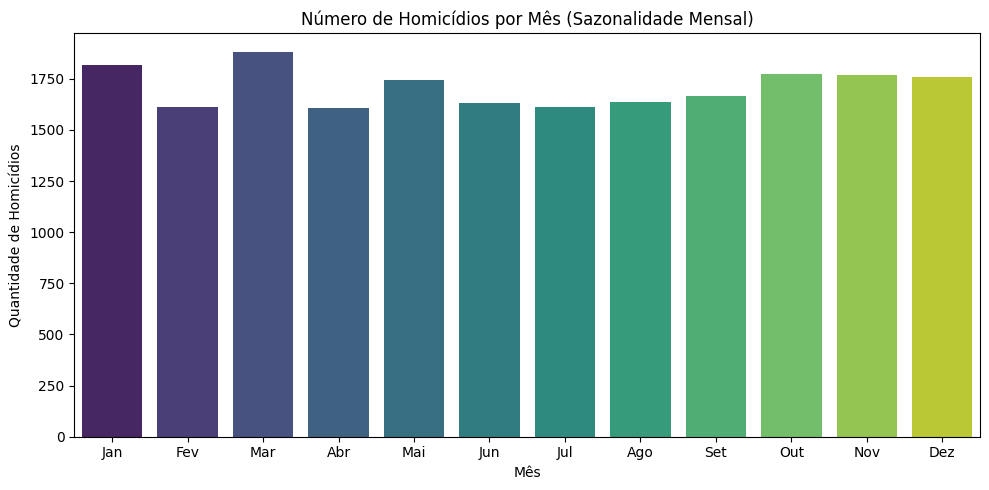

In [ ]:
# Agrupar por mês e contar
mensal = df.groupby('Mês').size()

# Plotar
plt.figure(figsize=(10, 5))
sns.barplot(x=mensal.index, y=mensal.values, palette='viridis')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.title('Número de Homicídios por Mês (Sazonalidade Mensal)')
plt.xlabel('Mês')
plt.ylabel('Quantidade de Homicídios')
plt.tight_layout()
plt.show()

In [ ]:
# Criando a coluna período com os valores "Antes de 2019" e "A partir de 2019"
df["Período"] = df["Ano"].apply(lambda x: "Antes de 2019" if x < 2019 else "A partir de 2019")

In [ ]:
# Criando dois agrupamentos: total de casos por ano e total por período (antes/depois de 2019)
por_ano = df.groupby("Ano").size().reset_index(name="Total")
por_periodo = df.groupby("Período").size().sort_index(ascending=False)

# Calculando a média anual de casos para cada período (antes e a partir de 2019)
por_periodo["Antes de 2019"] = por_periodo["Antes de 2019"] / len(df.query("Ano < 2019")["Ano"].unique())
por_periodo["A partir de 2019"] = por_periodo["A partir de 2019"] / len(df.query("Ano >= 2019")["Ano"].unique())

<ipython-input-81-ce31351e75bd>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1528.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  por_periodo["Antes de 2019"] = por_periodo["Antes de 2019"] / len(df.query("Ano < 2019")["Ano"].unique())


<ipython-input-63-13a8f8f5e646>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-63-13a8f8f5e646>:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


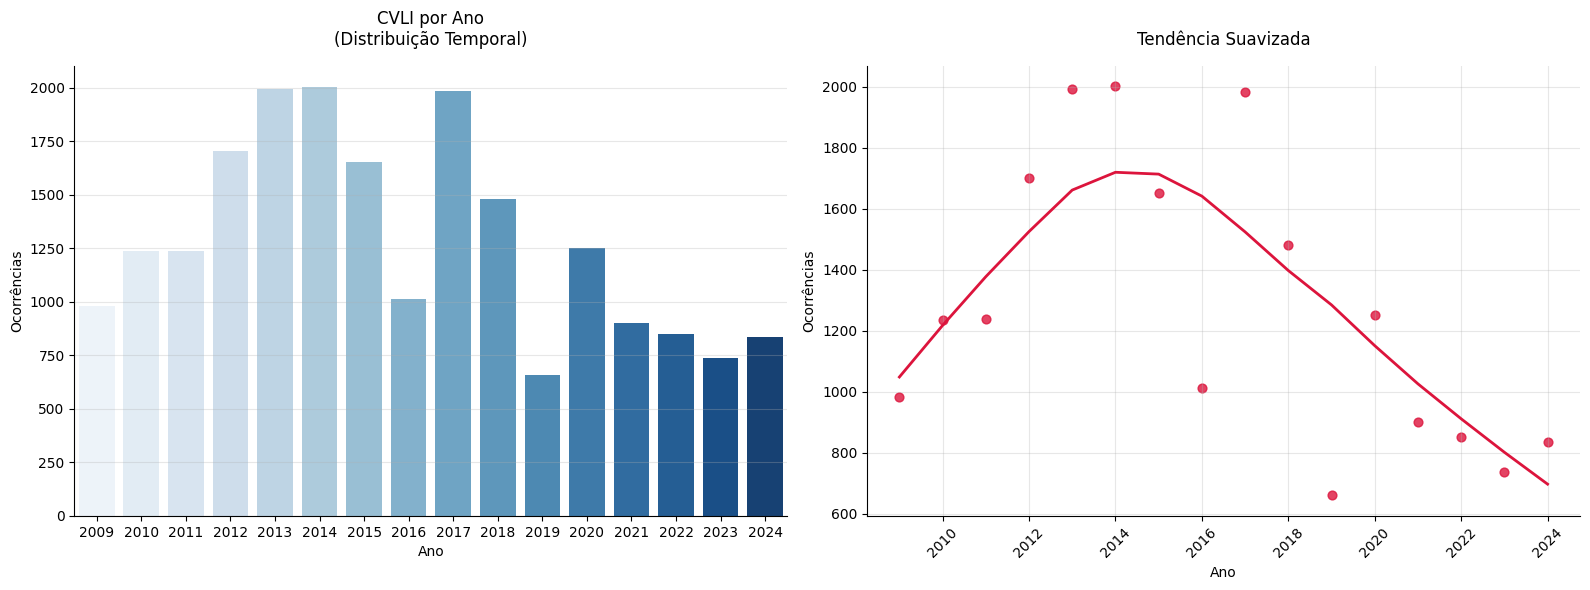

In [ ]:
time_series_with_trend(get_time_group(df.copy(),
                             time_col="Data",
                             time_unit='Y'),
                      title="CVLI por Ano",
                      xlabel="Ano")

<ipython-input-83-e41249b6f61d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=por_periodo.index, y=por_periodo.values, palette='Set2')


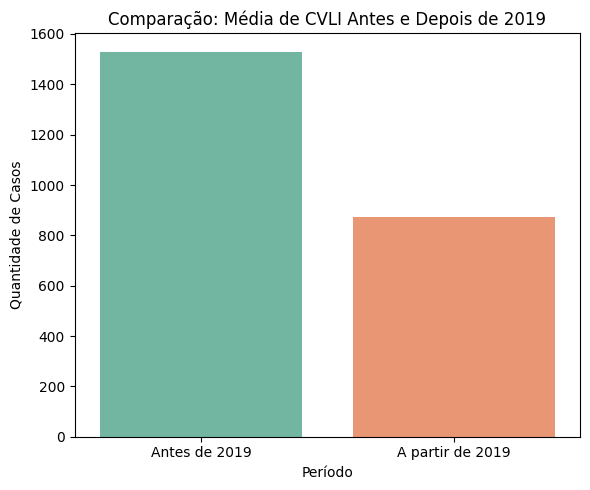

In [ ]:
# Gráfico de barras comparando a média anual de CVLIs antes e depois de 2019.
# Essa visualização destaca a queda significativa na média de homicídios após 2019.
plt.figure(figsize=(6, 5))
sns.barplot(x=por_periodo.index, y=por_periodo.values, palette='Set2')
plt.title('Comparação: Média de CVLI Antes e Depois de 2019')
plt.ylabel('Quantidade de Casos')
plt.xlabel('Período')
plt.tight_layout()
plt.show()

<ipython-input-84-99e7e1817ba6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=count_meio, x='Meio Empregado', y='Total', palette='coolwarm')


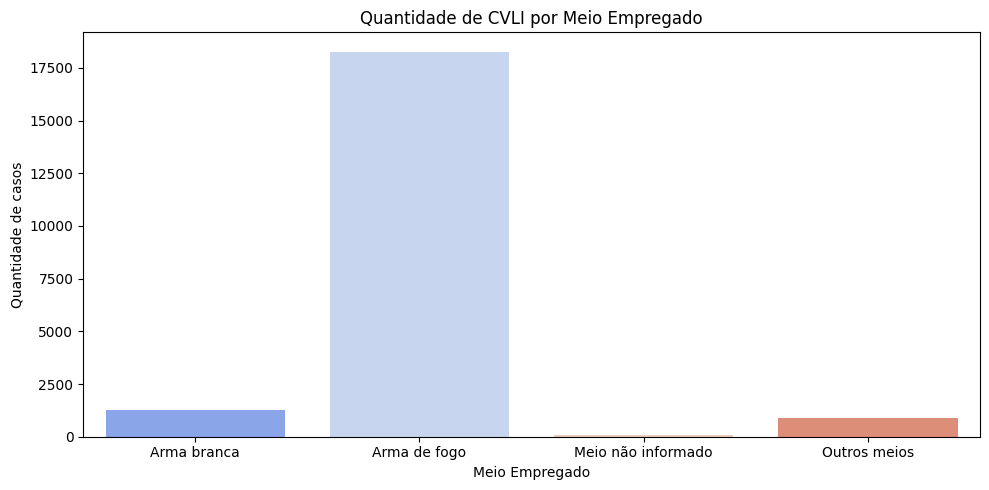

In [ ]:
# Gráfico de barras mostrando a quantidade de CVLIs de acordo com o meio empregado no crime.
# Permite identificar quais métodos (ex: arma de fogo, arma branca, etc.) são mais comuns nos homicídios.
count_meio = df.groupby("Meio Empregado").size().reset_index(name="Total")
plt.figure(figsize=(10, 5))
sns.barplot(data=count_meio, x='Meio Empregado', y='Total', palette='coolwarm')
plt.title('Quantidade de CVLI por Meio Empregado')
plt.xlabel('Meio Empregado')
plt.ylabel('Quantidade de casos')
plt.tight_layout()
plt.show()

In [ ]:
formats = [
    '%H:%M:%S.%f',  # Para horas com microssegundos (ex: 12:34:56.789)
    '%H:%M:%S',     # Para horas sem microssegundos (ex: 12:34:56)
    '%H:%M',        # Para horas sem segundos (ex: 12:34)
    '%I:%M:%S.%f %p',  # Formato 12h com microssegundos e AM/PM
    '%I:%M:%S %p'      # Formato 12h sem microssegundos com AM/PM
]

# Função para tentar vários formatos
def try_parse_time(time_str):
    for fmt in formats:
        try:
            return pd.to_datetime(time_str, format=fmt).time()
        except (ValueError, TypeError):
            continue
    return None

# Aplicar a função a cada valor
df['Hora'] = df['Hora'].apply(try_parse_time)

# Criar coluna com a hora inteira
df['Hora Inteira'] = df['Hora'].apply(lambda x: x.hour if x is not None else None)

# Removendo os registros com hora igual a 0 (meia-noite), pois podem representar dados faltantes ou default do sistema
df = df[df['Hora Inteira'] != 0]

In [ ]:
def classificar_periodo(hora):
    if pd.isnull(hora): return 'Desconhecido'
    if hora < 6: return 'Madrugada'
    elif hora < 12: return 'Manhã'
    elif hora < 18: return 'Tarde'
    else: return 'Noite'

df["Período do Dia"] = df["Hora Inteira"].apply(classificar_periodo)

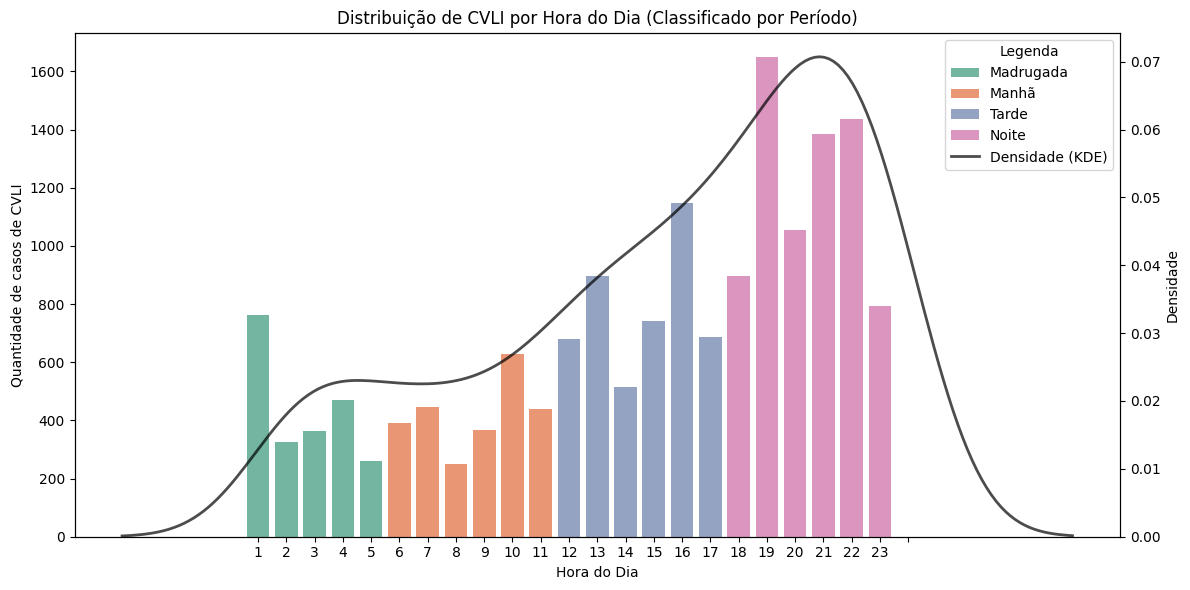

In [ ]:
plt.figure(figsize=(12, 6))

# Gráfico de barras (countplot)
ax1 = sns.countplot(data=df, x='Hora Inteira', hue='Período do Dia', palette='Set2')
plt.title('Distribuição de CVLI por Hora do Dia (Classificado por Período)')
plt.xlabel('Hora do Dia')
plt.ylabel('Quantidade de casos de CVLI')
plt.xticks(range(0, 24))

# Criando um segundo eixo y para a densidade
ax2 = ax1.twinx()

# Gráfico de densidade (KDE) - ajustando o parâmetro bw_method para suavização
sns.kdeplot(data=df, x='Hora Inteira', color='black', linewidth=2, alpha=0.7,
            bw_method=0.3, ax=ax2, label='Densidade (KDE)')
ax2.set_ylabel('Densidade')
ax2.grid(False)  # Remove grid do segundo eixo

# Combinando as legendas
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, title='Legenda')

plt.tight_layout()
plt.show()

A hora 0 foi excluída pois:
1.   Análise preliminar sugere padrão de preenchimento default usando 00:00:00 (não horário real)
2.   Pode distorcer análises de distribuição temporal